## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
import transformers

from radam import RAdam
from text_data import BertDataset
from xlnet import CustomXLNet
from learning import Learner
from lr_finder import LRFinder
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [4]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [6]:
num_workers = 10
bs = 2

## Training model

In [7]:
lr = 1e-5
device = 'cuda'
n_epochs = 5
grad_accum = 1
weight_decay = 0.1
model_output_dir = 'xlnet_1_output/'
pretrained_model = 'siamese_xlnet_1'
model_name = 'siamese_xlnet_1_head'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
loss_fn = nn.BCEWithLogitsLoss()

In [8]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomXLNet(256, cat_features_train.shape[1])
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

Fold 1 started at Sun Feb  2 16:16:01 2020


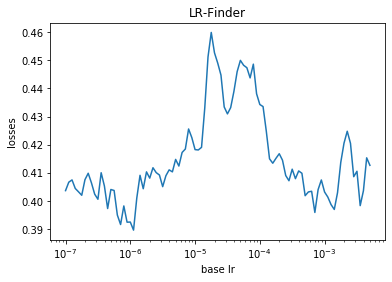

epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44961 - spearmanr 0.42033
best model: epoch -1 - 0.42033
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/5 	 train : loss 0.41436 - spearmanr 0.50734
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44835 - spearmanr 0.42283
best model: epoch 0 - 0.42283
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41202 - spearmanr 0.51258
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4484 - spearmanr 0.42369
best model: epoch 1 - 0.42369
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.4103 - spearmanr 0.51614
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44839 - spearmanr 0.42404
best model: epoch 2 - 0.42404
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40914 - spearmanr 0.51916
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44858 - spearmanr 0.4241
best model: epoch 3 - 0.4241
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40818 - spearmanr 0.52122
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44865 - spearmanr 0.42438
best model: epoch 4 - 0.42438
TRAINING END: Best score achieved on epoch 4 - 0.42438
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_1_best.pth



Fold 2 started at Sun Feb  2 16:22:54 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45602 - spearmanr 0.42646
best model: epoch -1 - 0.42646
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40381 - spearmanr 0.52961
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4529 - spearmanr 0.42669
best model: epoch 0 - 0.42669
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40251 - spearmanr 0.53189
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45293 - spearmanr 0.42658
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40114 - spearmanr 0.53542
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45301 - spearmanr 0.42647
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40028 - spearmanr 0.53794
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45319 - spearmanr 0.4262
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39943 - spearmanr 0.53919
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45345 - spearmanr 0.42609
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.42669
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_2_best.pth



Fold 3 started at Sun Feb  2 16:25:01 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45372 - spearmanr 0.40987
best model: epoch -1 - 0.40987
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41361 - spearmanr 0.50853
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45208 - spearmanr 0.41287
best model: epoch 0 - 0.41287
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.4111 - spearmanr 0.51437
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4522 - spearmanr 0.41318
best model: epoch 1 - 0.41318
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40991 - spearmanr 0.51677
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45225 - spearmanr 0.41332
best model: epoch 2 - 0.41332
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40925 - spearmanr 0.51797
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45245 - spearmanr 0.413
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40783 - spearmanr 0.52158
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45272 - spearmanr 0.41247
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41332
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_3_best.pth



Fold 4 started at Sun Feb  2 16:27:08 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45793 - spearmanr 0.39923
best model: epoch -1 - 0.39923
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40235 - spearmanr 0.53411
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45523 - spearmanr 0.3994
best model: epoch 0 - 0.3994
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40067 - spearmanr 0.53783
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45512 - spearmanr 0.39904
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39975 - spearmanr 0.53995
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45514 - spearmanr 0.39872
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.3986 - spearmanr 0.54238
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.4553 - spearmanr 0.39826
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39777 - spearmanr 0.54458
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45562 - spearmanr 0.39775
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.39940
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_4_best.pth



Fold 5 started at Sun Feb  2 16:29:16 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4513 - spearmanr 0.40386
best model: epoch -1 - 0.40386
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41332 - spearmanr 0.50982
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44912 - spearmanr 0.40625
best model: epoch 0 - 0.40625
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41117 - spearmanr 0.51431
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4493 - spearmanr 0.40681
best model: epoch 1 - 0.40681
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40967 - spearmanr 0.51718
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44962 - spearmanr 0.40691
best model: epoch 2 - 0.40691
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40845 - spearmanr 0.5201
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44994 - spearmanr 0.40671
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40764 - spearmanr 0.52214
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44981 - spearmanr 0.40649
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40691
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_5_best.pth



Fold 6 started at Sun Feb  2 16:31:17 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45166 - spearmanr 0.39319
best model: epoch -1 - 0.39319
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41335 - spearmanr 0.51122
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4478 - spearmanr 0.39771
best model: epoch 0 - 0.39771
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41063 - spearmanr 0.51716
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44787 - spearmanr 0.39866
best model: epoch 1 - 0.39866
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40944 - spearmanr 0.5198
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44817 - spearmanr 0.39849
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40786 - spearmanr 0.52338
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44851 - spearmanr 0.39822
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40713 - spearmanr 0.5251
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44884 - spearmanr 0.39777
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39866
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_6_best.pth



Fold 7 started at Sun Feb  2 16:33:18 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45989 - spearmanr 0.41568
best model: epoch -1 - 0.41568
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40277 - spearmanr 0.53184
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45702 - spearmanr 0.4165
best model: epoch 0 - 0.4165
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40085 - spearmanr 0.536
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45692 - spearmanr 0.41656
best model: epoch 1 - 0.41656
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39971 - spearmanr 0.53893
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45721 - spearmanr 0.41648
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39851 - spearmanr 0.54138
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45739 - spearmanr 0.41627
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39783 - spearmanr 0.54268
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45777 - spearmanr 0.41602
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41656
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_7_best.pth



Fold 8 started at Sun Feb  2 16:35:23 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.46673 - spearmanr 0.41361
best model: epoch -1 - 0.41361
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40058 - spearmanr 0.53505
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4635 - spearmanr 0.41384
best model: epoch 0 - 0.41384
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.3987 - spearmanr 0.53939
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4634 - spearmanr 0.41361
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39787 - spearmanr 0.54112
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.46378 - spearmanr 0.41349
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39665 - spearmanr 0.54355
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.46416 - spearmanr 0.41352
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39565 - spearmanr 0.54595
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.46435 - spearmanr 0.41298
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.41384
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_8_best.pth



Fold 9 started at Sun Feb  2 16:37:26 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45142 - spearmanr 0.40596
best model: epoch -1 - 0.40596
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41194 - spearmanr 0.51298
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4499 - spearmanr 0.40901
best model: epoch 0 - 0.40901
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40996 - spearmanr 0.51642
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44992 - spearmanr 0.40973
best model: epoch 1 - 0.40973
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40868 - spearmanr 0.51965
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44978 - spearmanr 0.4104
best model: epoch 2 - 0.4104
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40781 - spearmanr 0.52133
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45017 - spearmanr 0.41051
best model: epoch 3 - 0.41051
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.4065 - spearmanr 0.52446
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45031 - spearmanr 0.41091
best model: epoch 4 - 0.41091
TRAINING END: Best score achieved on epoch 4 - 0.41091
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_9_best.pth



Fold 10 started at Sun Feb  2 16:39:27 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44692 - spearmanr 0.41828
best model: epoch -1 - 0.41828
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41417 - spearmanr 0.50811
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44175 - spearmanr 0.42153
best model: epoch 0 - 0.42153
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41185 - spearmanr 0.51358
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44148 - spearmanr 0.42273
best model: epoch 1 - 0.42273
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41023 - spearmanr 0.51631
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44163 - spearmanr 0.42283
best model: epoch 2 - 0.42283
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.409 - spearmanr 0.51885
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44164 - spearmanr 0.42322
best model: epoch 3 - 0.42322
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40807 - spearmanr 0.52186
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44183 - spearmanr 0.42293
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.42322
Starting inference for model: checkpoints/siamese_xlnet_1_head_fold_10_best.pth



OOF score: 0.41394404558701375


In [9]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{model_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [10]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.479968935918637
5 4 0.4590639420013309
9 32 0.13162662418885054
11 8 0.7582289213419167
12 4 0.5521667696552108
13 4 0.3117223947275163
14 4 0.6186936914023693
15 4 0.600709382559366
19 64 0.219982897315666


In [11]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 32,  8,  4,  4,  4,  4, 64]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 19]))

In [12]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [13]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.413944
CV unique rows,0.376354
CV ignoring hard targets,0.437858
CV unique rows ignoring hard targets,0.397649
CV w rounding,0.447921
CV unique rows w rounding,0.425353
CV ignoring hard targets w rounding,0.467358
CV unique rows ignoring hard targets w rounding,0.437711


In [14]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.417931
CV unique rows,0.380435
CV ignoring hard targets,0.437858
CV unique rows ignoring hard targets,0.397649
CV w rounding,0.449036
CV unique rows w rounding,0.425353
CV ignoring hard targets w rounding,0.467358
CV unique rows ignoring hard targets w rounding,0.437711


In [15]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [16]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [17]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [18]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.822999,0.635545,0.325477,0.675204,0.466416,0.339730,0.652207,0.557707,0.076105,0.006967,0.680579,0.100769,0.241118,0.030369,0.009870,0.287779,0.145112,0.101728,0.472555,0.000944,0.774516,0.904110,0.562606,0.962481,0.956636,0.723070,0.184693,0.095457,0.797475,0.786723
1,0.829705,0.611935,0.040629,0.627794,0.921025,0.702167,0.599594,0.645955,0.354166,0.000805,0.264566,0.061927,0.740744,0.004182,0.704712,0.034850,0.098000,0.071369,0.464161,0.005098,0.758818,0.523259,0.267296,0.732714,0.772252,0.340435,0.031394,0.024876,0.443191,0.741702
2,0.583834,0.279225,0.006599,0.678760,0.744788,0.851375,0.435839,0.216904,0.122513,0.002284,0.403958,0.142724,0.003587,0.002982,0.001837,0.253652,0.726269,0.229919,0.176780,0.000081,0.518958,0.897383,0.642406,0.932279,0.917212,0.748447,0.668263,0.280664,0.568720,0.773887
3,0.822430,0.723447,0.053638,0.862138,0.888518,0.943766,0.533578,0.559315,0.318100,0.000922,0.136806,0.965062,0.017315,0.006420,0.090738,0.022041,0.041279,0.096662,0.406935,0.001319,0.770025,0.870365,0.696333,0.900278,0.920707,0.744991,0.029321,0.074917,0.830954,0.589789
4,0.780605,0.747307,0.001934,0.611861,0.820003,0.898372,0.413703,0.399844,0.220949,0.000378,0.336534,0.614760,0.000969,0.000333,0.000293,0.001949,0.910730,0.320035,0.083871,0.000010,0.778059,0.777323,0.403630,0.861944,0.845685,0.531164,0.905596,0.244246,0.046415,0.663537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.854389,0.488576,0.107145,0.778937,0.657921,0.779355,0.581140,0.609395,0.577698,0.003100,0.549742,0.951712,0.086214,0.469886,0.004404,0.066722,0.009568,0.034528,0.763683,0.003833,0.690759,0.923392,0.757434,0.938159,0.926254,0.755481,0.102316,0.141876,0.919342,0.724342
6075,0.876645,0.240536,0.072917,0.451429,0.493991,0.253145,0.757676,0.748659,0.033687,0.001795,0.700211,0.004587,0.004206,0.004182,0.000619,0.005248,0.816480,0.354927,0.159853,0.000022,0.728086,0.840751,0.527222,0.917672,0.931177,0.601727,0.884836,0.334953,0.221992,0.872722
6076,0.599930,0.387402,0.005712,0.684306,0.721433,0.915887,0.397696,0.281341,0.136810,0.004035,0.447775,0.641063,0.001452,0.000517,0.000639,0.004241,0.823546,0.353541,0.170433,0.000076,0.473193,0.559393,0.369805,0.775287,0.749920,0.343060,0.642015,0.210024,0.499039,0.441862
6077,0.862199,0.650277,0.831214,0.288143,0.191737,0.094318,0.595783,0.723582,0.568297,0.000396,0.946894,0.658925,0.073472,0.039865,0.001155,0.014359,0.013257,0.108030,0.667435,0.000012,0.892371,0.754690,0.640049,0.888602,0.906749,0.669567,0.015015,0.086168,0.835086,0.830805


In [19]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.390970
question_body_critical                   0.622737
question_conversational                  0.413239
question_expect_short_answer             0.297908
question_fact_seeking                    0.368480
question_has_commonly_accepted_answer    0.425784
question_interestingness_others          0.358915
question_interestingness_self            0.503881
question_multi_intent                    0.585673
question_not_really_a_question           0.090638
question_opinion_seeking                 0.480087
question_type_choice                     0.743545
question_type_compare                    0.365484
question_type_consequence                0.187360
question_type_definition                 0.362167
question_type_entity                     0.456981
question_type_instructions               0.781207
question_type_procedure                  0.374138
question_type_reason_explanation         0.670821
question_type_spelling                   0.067662


In [20]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.067662,3.0
question_not_really_a_question,0.090638,5.0
answer_plausible,0.143312,9.0
answer_relevance,0.174479,9.0
question_type_consequence,0.187360,5.0
answer_well_written,0.226319,9.0
answer_helpful,0.244134,9.0
question_expect_short_answer,0.297908,5.0
answer_type_procedure,0.307295,5.0
question_interestingness_others,0.358915,9.0


In [21]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

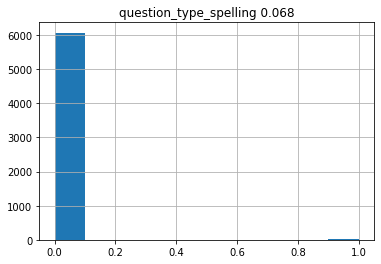

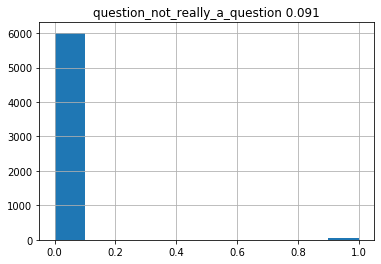

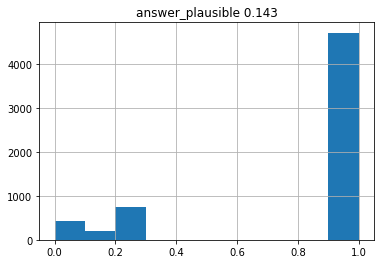

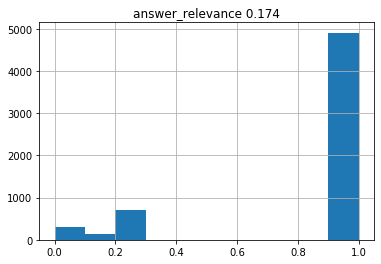

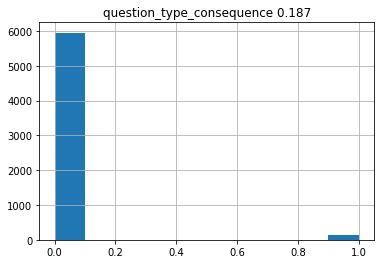

In [22]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


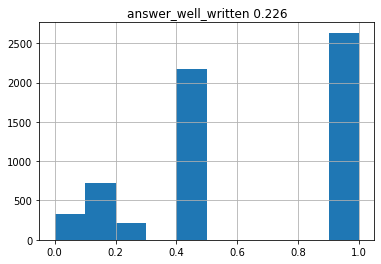

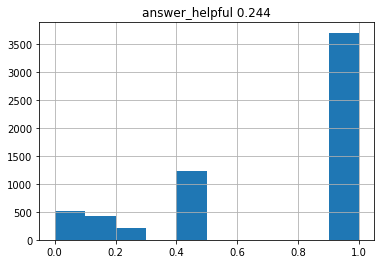

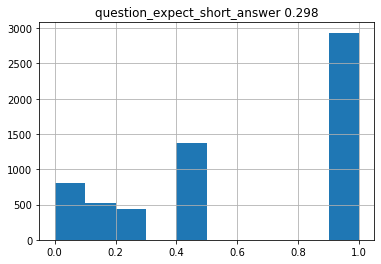

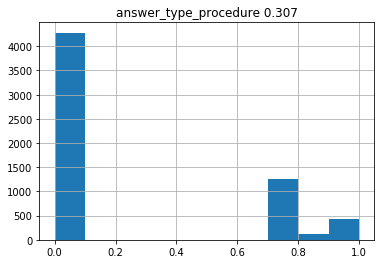

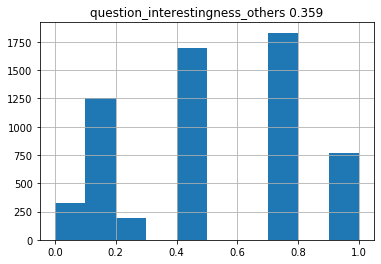

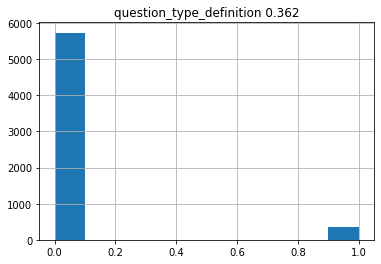

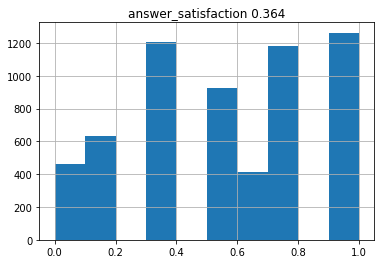

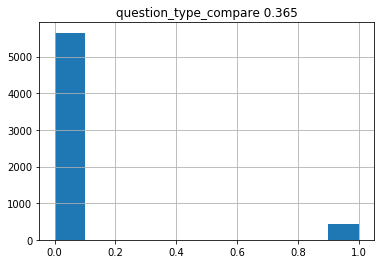

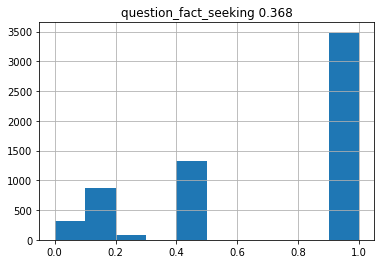

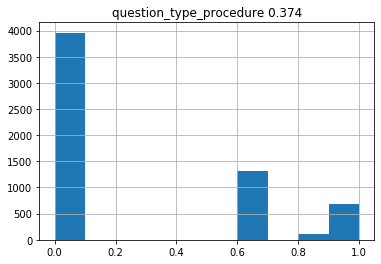

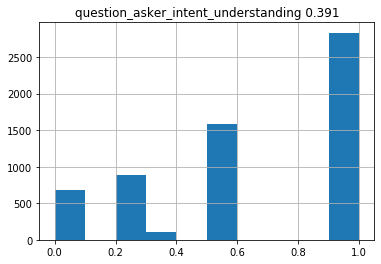

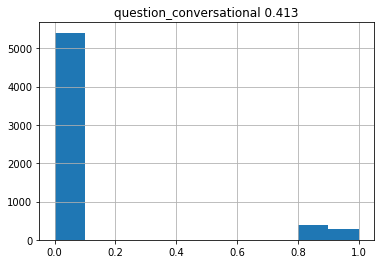

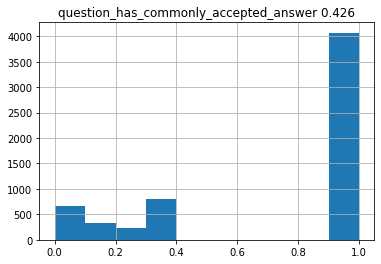

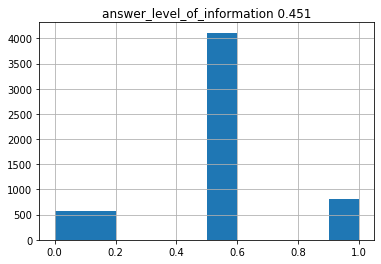

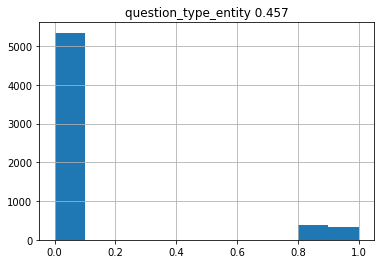

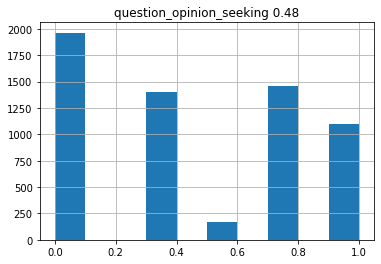

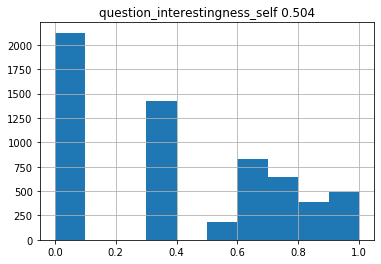

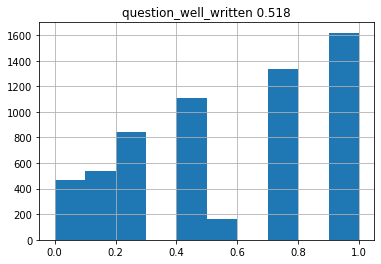

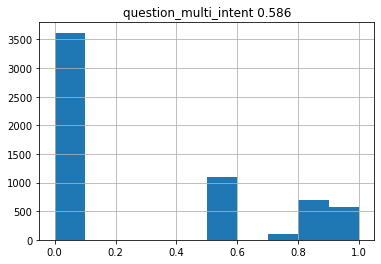

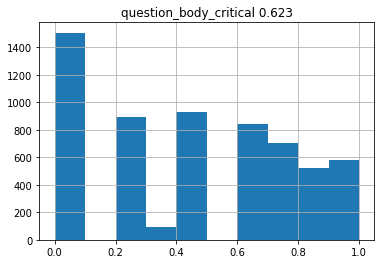

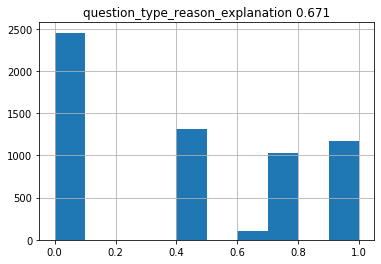

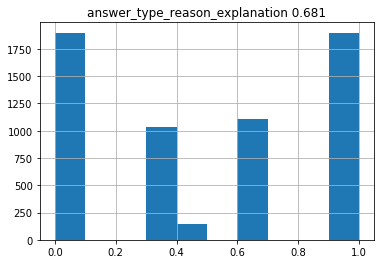

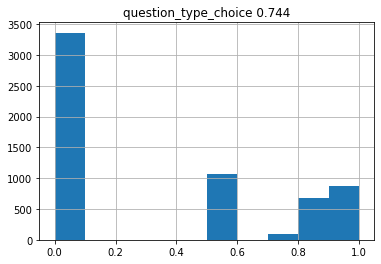

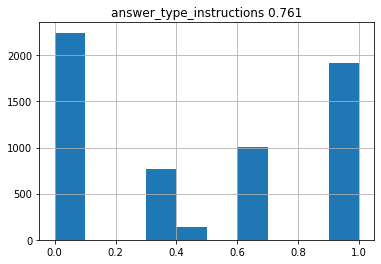

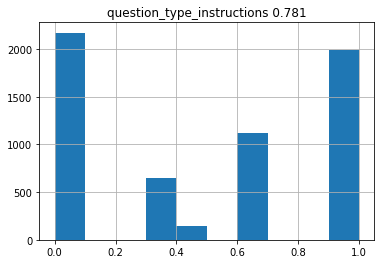

In [23]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')